In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, embed_signal, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Get Signals

In [7]:
session_info['drugStart']/60

array([19.25317778, 49.25317778])

In [28]:
window = 5000 # ms 
start_time1 = 4000 # ms
start_time2 = 55*60*1000 # ms
indices = np.where(electrode_info['area'] == 'vlPFC')[0]

signal_in_wake = lfp[start_time1:window + start_time1, indices]
signal_in_anesthesia = lfp[start_time2:window + start_time2, indices]

# Analyze Dimensionality

In [251]:
U_wake, S_wake, Vh_wake = np.linalg.svd(signal_in_wake)
U_anesthesia, S_anesthesia, Vh_anesthesia = np.linalg.svd(signal_in_anesthesia)

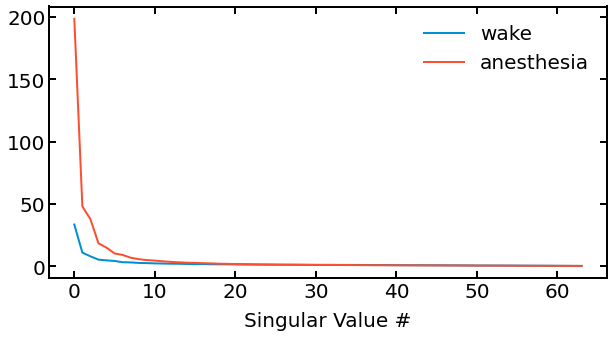

In [252]:
plt.plot(S_wake, label='wake')
plt.plot(S_anesthesia, label='anesthesia')
plt.legend()
plt.xlabel("Singular Value #")
plt.show()

# VAR(p)

In [253]:
results_dict = {}

In [84]:
for i, (signal_in, key) in enumerate([(signal_in_wake, 'wake'), (signal_in_anesthesia, 'anesthesia')]):
    print(key)
    N = signal_in.shape[1]
    p = 15
    X_p = np.zeros((N*p + 1, window - p))
    Y_p = np.zeros((N*p, window - p))
    for t in range(window - p):
        for i in range(p):
            X_p[i*N:(i + 1)*N, t] = signal_in[t + p - 1 - i]
            Y_p[i*N:(i + 1)*N, t] = signal_in[t + p - i]
    X_p[-1] = np.ones(window - p)
    U, S, Vh = np.linalg.svd(X_p)
    S_mat = np.zeros((N*p + 1, window - p))
    S_mat[np.arange(N*p + 1), np.arange(N*p + 1)] = S

    lambda_vals = np.hstack([[0], np.arange(0.001, 0.01, 0.001), np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1, 0.05), np.arange(1, 2.01, 0.1)])
    all_coefs = np.zeros((len(lambda_vals), p, N, N))
    intercepts = np.zeros((len(lambda_vals), N))
    all_eigs = np.zeros((len(lambda_vals), N*p), dtype=complex)
    all_criticalities = np.zeros((len(lambda_vals), N*p))
    # S_mat_cov = S_mat.T @ S_mat
    # right_side = S_mat.T @ U.T
    S_mat_inv = S_mat.copy().T
    left_side = Y_p[:N] @ Vh.T
    for i, lamb in tqdm(enumerate(lambda_vals), total=len(lambda_vals)):
        if lamb == 0:
    #         full_mat = Y_p[:N] @ Vh.T @ np.linalg.pinv(S_mat) @ U.T
            ret = compute_VAR_p(signal_in, p=p)
            all_coefs[i] = ret['coefs']
            intercepts[i] = ret['intercept']
        else:
    #         full_mat = left_side @ np.linalg.inv(S_mat_cov + lamb*np.eye(S_mat.shape[1])) @ right_side
            S_mat_inv[np.arange(N*p + 1), np.arange(N*p + 1)] = S/(S**2 + lamb)
            full_mat = left_side @ S_mat_inv @ U.T
            intercepts[i] = full_mat[:, -1]
            coefs = np.zeros((p, N, N))
            for j in range(p):
                coefs[j] = full_mat[:, j*N:(j + 1)*N]
            all_coefs[i] = coefs

        A_mat = np.zeros((N*p, N*p))
        for j in range(p):
            A_mat[0:N][:, j*N:(j+1)*N] = all_coefs[i][j]

        for j in range(p - 1):
            A_mat[(j + 1)*N:(j + 2)*N][:, j*N:(j + 1)*N] = np.eye(N)
        e = np.linalg.eigvals(A_mat)   
        all_eigs[i] = e  
        all_criticalities[i] = np.sort(np.abs(e))
    
    results_dict[key] = dict(
        all_coefs=all_coefs,
        intercepts=intercepts,
        all_eigs=all_eigs,
        all_criticalities=all_criticalities
    )

wake


  0%|          | 0/48 [00:00<?, ?it/s]

anesthesia


  0%|          | 0/48 [00:00<?, ?it/s]

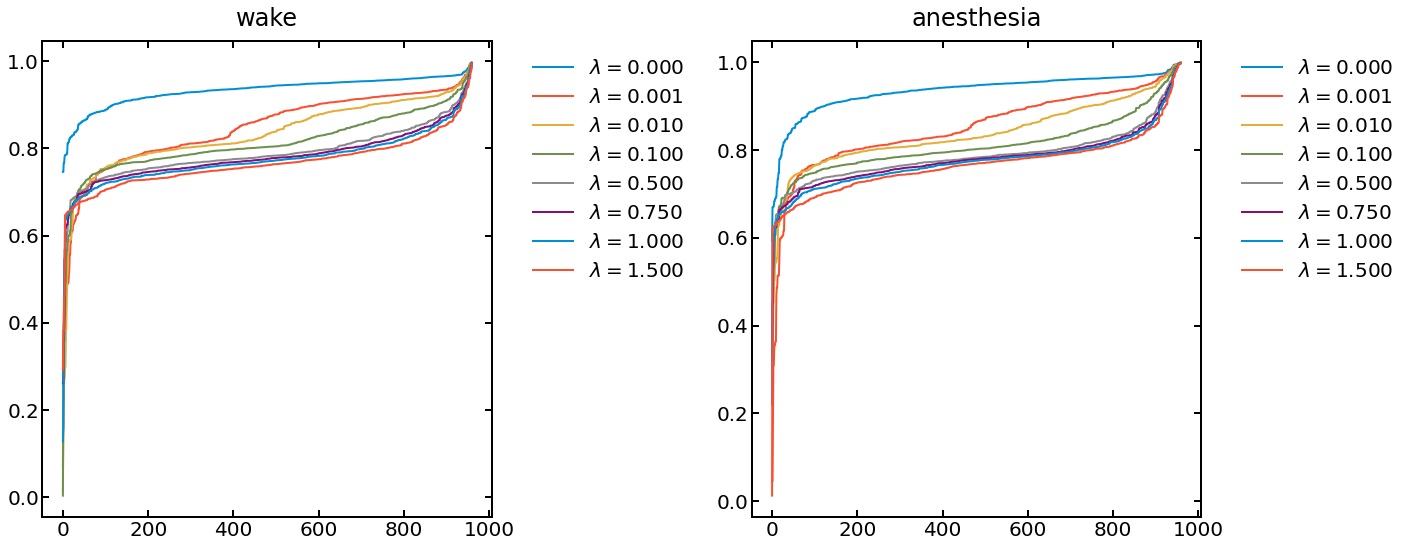

In [85]:
plt.figure(figsize=(20, 8))
for i, key in enumerate(['wake', 'anesthesia']):
    all_criticalities = results_dict[key]['all_criticalities']
    plt.subplot(1, 2, i + 1)
    for ind in [0, 1, 10, 19, 27, 32, 37, 42]:   
        plt.plot(all_criticalities[ind], label=r"$\lambda = $" + f"{lambda_vals[ind]:.3f}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(key)
plt.tight_layout()
plt.show()

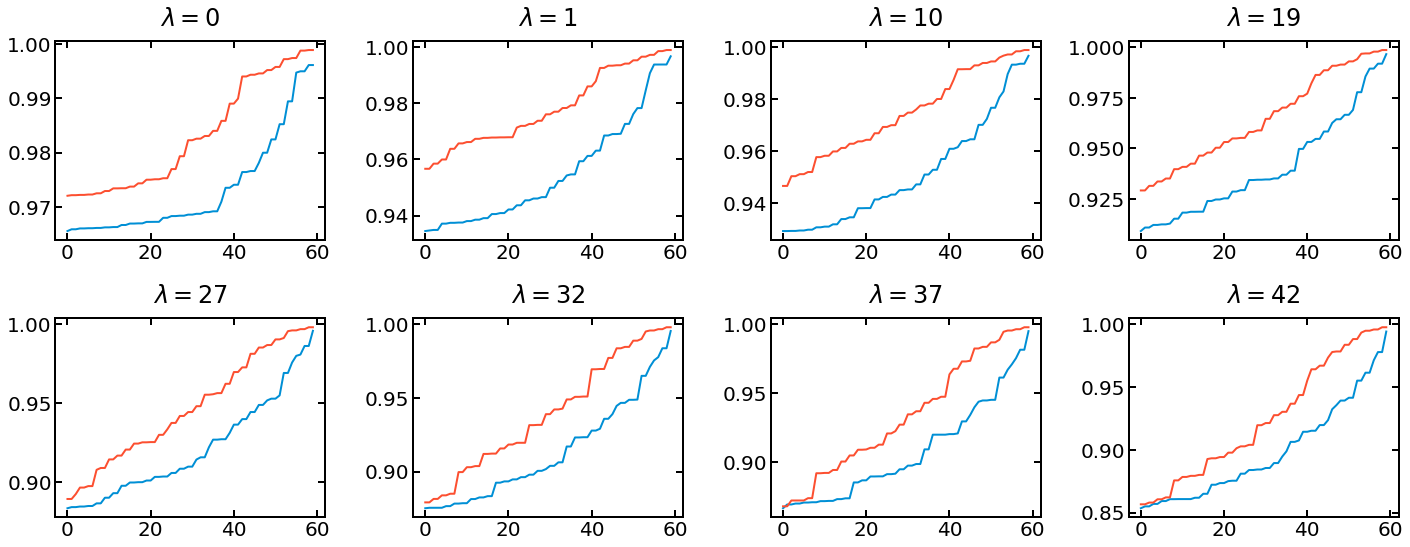

In [88]:
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 8))
inds = [0, 1, 10, 19, 27, 32, 37, 42]
for i in range(int(rows*cols)):
    ax = axs[int(i/cols)][i % cols]
    ax.plot(results_dict['wake']['all_criticalities'][inds[i]][900:])
    ax.plot(results_dict['anesthesia']['all_criticalities'][inds[i]][900:])
    ax.set_title(r"$\lambda = $" + f"{inds[i]}")
plt.tight_layout()
plt.show()

# EDMD?

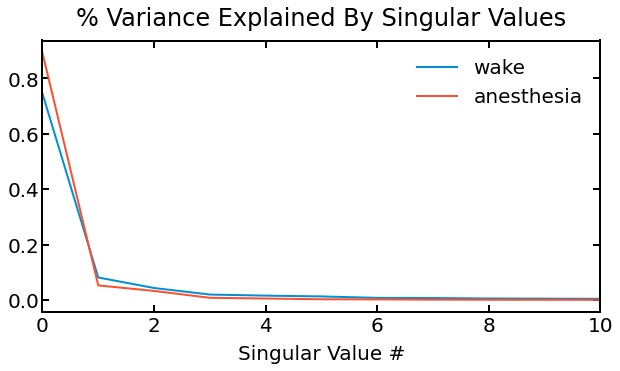

In [254]:
# variance explained
plt.plot(S_wake**2/np.sum(S_wake**2), label='wake')
plt.plot(S_anesthesia**2/np.sum(S_anesthesia**2), label='anesthesia')
plt.legend()
plt.xlabel("Singular Value #")
plt.title("% Variance Explained By Singular Values")
plt.xlim([0, 10])
plt.show()

In [255]:
p = 10
PCA_dim = 5
results_wake = compute_VAR_p(signal_in_wake, p=p, lamb=0, PCA_dim=PCA_dim)
results_anesthesia = compute_VAR_p(signal_in_anesthesia, p=p, lamb=0, PCA_dim=PCA_dim)

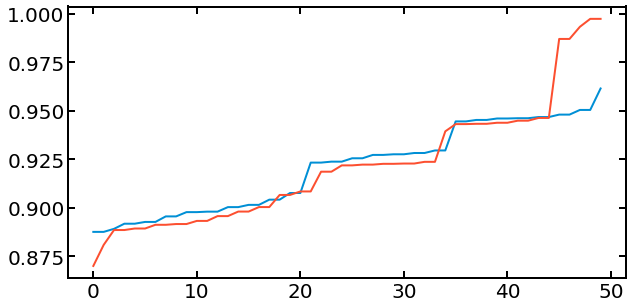

In [256]:
plt.plot(np.sort(results_wake['criticality_inds']))
plt.plot(np.sort(results_anesthesia['criticality_inds']))

In [127]:
T_pred = 25
pred_signal_wake = lfp[start_time1 + window - p:window + start_time1 + T_pred, indices]
pred_signal_anesthesia = lfp[start_time2 + window - p:window + start_time2 + T_pred, indices]

In [128]:
prediction, true_vals, pb_mse = predict_VAR_p(pred_signal_wake, results_wake['coefs'], results_wake['intercept'], persistence_baseline=True, PCA_dim=PCA_dim)

In [129]:
f"pb_mse = {pb_mse:.2e}, prediction mse = {((prediction - true_vals)**2).mean():.2e}"

'pb_mse = 3.43e-04, prediction mse = 5.98e-06'

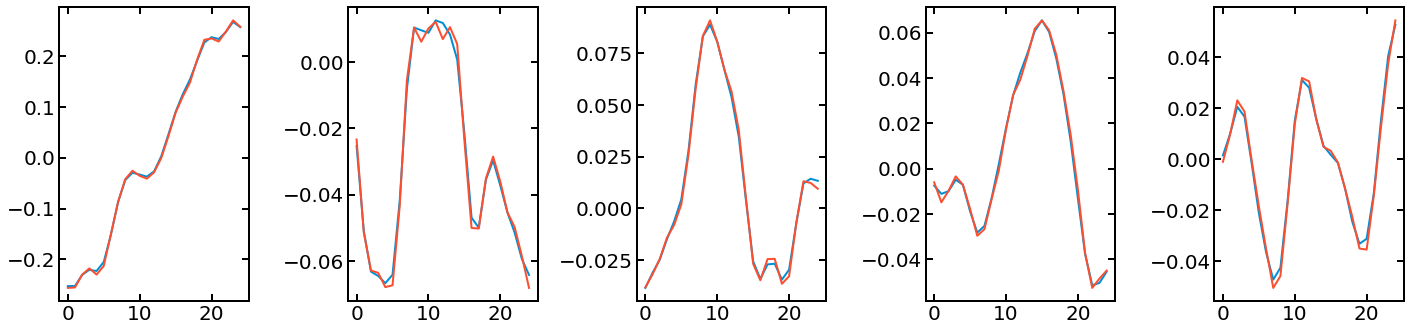

In [130]:
rows = 1
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 5))
for i in range(int(rows*cols)):
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    ax.plot(true_vals[:, i])
    ax.plot(prediction[:, i])
plt.tight_layout()
plt.show()

# EDMD + PCA

In [70]:
p = 12
lamb = 1e-12
# lamb = 0
max_order = 2
PCA_dim = 3
dim_init = PCA_dim if PCA_dim > 1 else len(indices)
grouped_by = dim_init
include_signal = True
normalize=False

N_groups = int(np.ceil(dim_init*p/grouped_by))
D = ((max_order + 1)**grouped_by - 1)*N_groups + 1
if include_signal:
    D += len(indices)*p
print(f"Dictionary dimension is {D}")

Dictionary dimension is 1081


In [71]:
%%time
results_wake = compute_EDMD(signal_in_wake, p=p, lamb=lamb, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=normalize, PCA_dim=PCA_dim)
results_anesthesia = compute_EDMD(signal_in_anesthesia, p=p, lamb=lamb, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=normalize, PCA_dim=PCA_dim)

CPU times: user 34.1 s, sys: 261 ms, total: 34.4 s
Wall time: 17.4 s


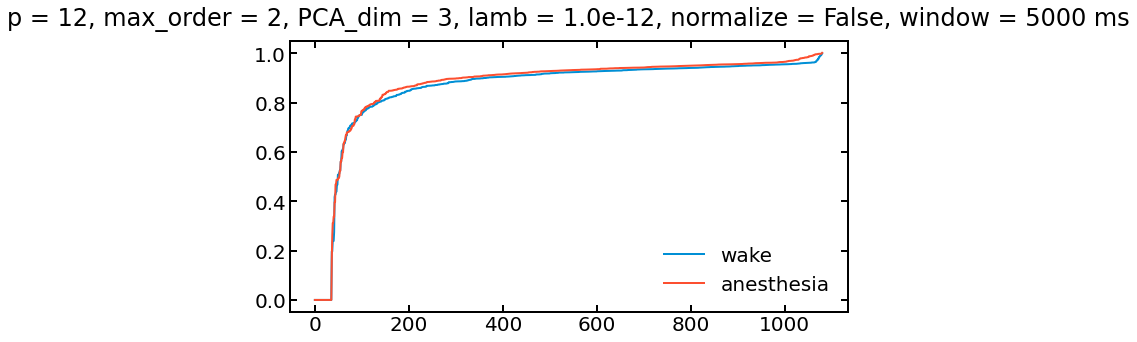

In [72]:
lamb_str = f"{lamb:.1e}" if lamb < 0.001 else f"{lamb:.3f}"
plt.title(f"p = {p}, max_order = {max_order}, PCA_dim = {PCA_dim}, lamb = {lamb_str}, normalize = {normalize}, window = {window} ms")
plt.plot(np.sort(results_wake['criticality_inds']), label='wake')
plt.plot(np.sort(results_anesthesia['criticality_inds']), label='anesthesia')
plt.legend()
plt.show()

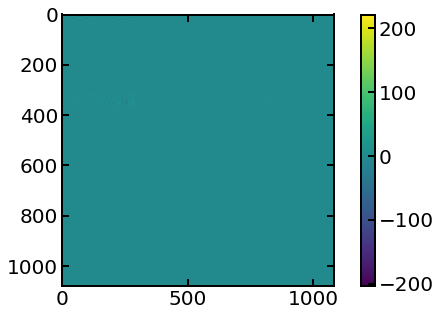

In [73]:
plt.imshow(results_wake['coefs']), plt.colorbar()
# plt.imshow(results_wake['coefs'][actual_indices, :][:, actual_indices], aspect='auto'), plt.colorbar()
# plt.imshow(results_wake['coefs'][:, actual_indices], aspect='auto'), plt.colorbar()
plt.show()

In [78]:
T_pred = 500

# test
pred_signal_wake = lfp[start_time1 + window - p:window + start_time1 + T_pred, indices]
pred_signal_anesthesia = lfp[start_time2 + window - p:window + start_time2 + T_pred, indices]

# # train
# pred_signal_wake = lfp[start_time1:window + start_time1, indices]
# pred_signal_anesthesia = lfp[start_time2:window + start_time2, indices]

In [79]:
predict_type = 'actual'
tail_bite = True
prediction = {}
true_vals = {}
pb_mse = {}
pb = {}

if D > window:
    U_wake = results_wake['U']
    U_anesthesia = results_anesthesia['U']
    predict_type = 'all'
else:
    U_wake = None
    U_anesthesia = None
prediction['wake'], true_vals['wake'], pb_mse['wake'], pb['wake'] = predict_EDMD(pred_signal_wake, results_wake['coefs'], p=p, intercept=results_wake['intercept'], U=U_wake, max_order=max_order, grouped_by=grouped_by, include_signal=include_signal, normalize=results_wake['normalize'], predict_type=predict_type, tail_bite=tail_bite, persistence_baseline=True, PCA_dim=PCA_dim)
prediction['anesthesia'], true_vals['anesthesia'], pb_mse['anesthesia'], pb['anesthesia'] = predict_EDMD(pred_signal_anesthesia, results_anesthesia['coefs'], p=p, intercept=results_anesthesia['intercept'], U=U_anesthesia, max_order=max_order, grouped_by=grouped_by,  include_signal=include_signal, normalize=results_anesthesia['normalize'], predict_type=predict_type, tail_bite=tail_bite, persistence_baseline=True, PCA_dim=PCA_dim)

In [80]:
for key in ['wake', 'anesthesia']:
    print(f"{key}: pb_mse = {pb_mse[key]:.2e}, prediction mse = {((prediction[key] - true_vals[key])**2).mean():.2e}")

wake: pb_mse = 5.08e-05, prediction mse = 1.37e+01
anesthesia: pb_mse = 5.89e-05, prediction mse = 1.48e+00


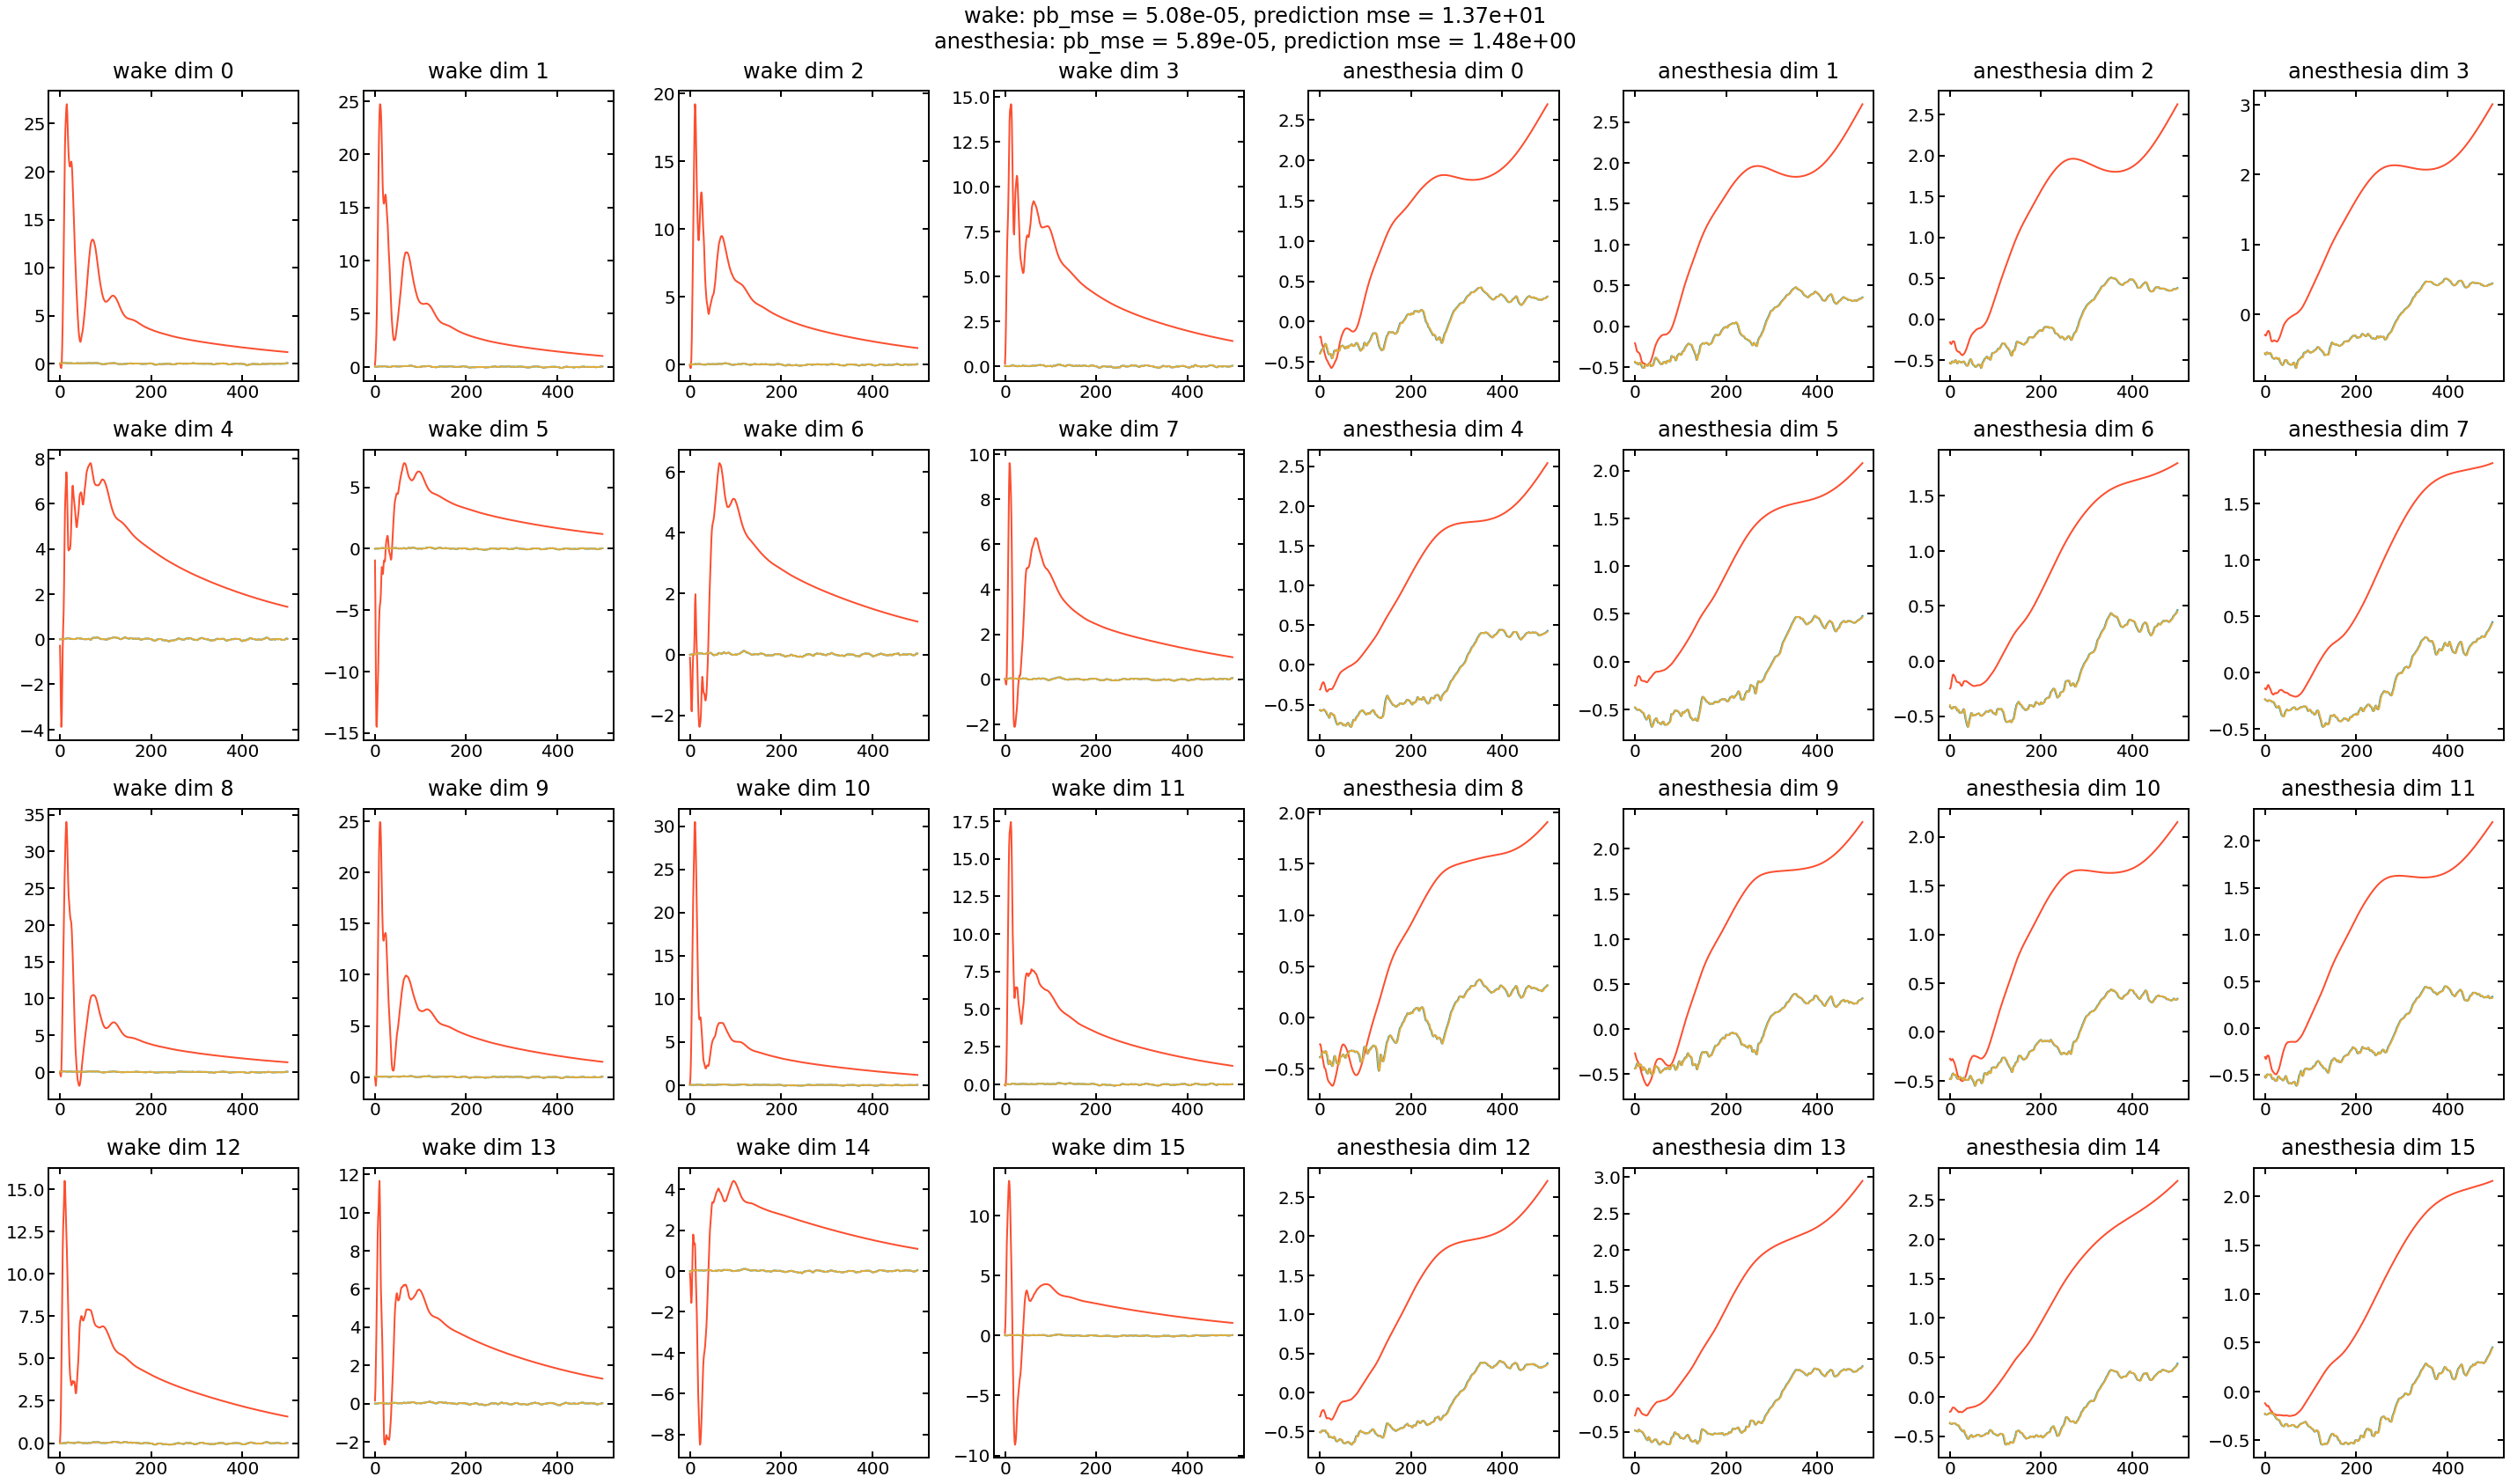

In [81]:
if predict_type == 'actual':
#     rows = 1
#     cols = 10
    rows = 4
    cols = 8
    fig, axs = plt.subplots(rows, cols, figsize=(40, 24))
else: # predict_type == 'all'
    rows = 5
    cols = 10
    fig, axs = plt.subplots(rows, cols, figsize=(40, 18))

n_plots = rows*cols
    
for i in range(n_plots):
    if i % cols > int(cols/2) - 1:
        key = 'anesthesia'
    else:
        key = 'wake'
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if key == 'wake':
        dim_ind = i - int(i/cols)*int(cols/2)
    else:
        dim_ind = i - (int(i/cols) + 1)*int(cols/2)
    ax.plot(true_vals[key][:, dim_ind])
#     ax.plot(pred_signal_wake[p:, dim_ind])
    ax.plot(prediction[key][:, dim_ind])
    ax.plot(pb[key][:, dim_ind])
    ax.set_title(f"{key} dim {dim_ind}")

plt.suptitle(f"wake: pb_mse = {pb_mse['wake']:.2e}, prediction mse = {((prediction['wake'] - true_vals['wake'])**2).mean():.2e}\nanesthesia: pb_mse = {pb_mse['anesthesia']:.2e}, prediction mse = {((prediction['anesthesia'] - true_vals['anesthesia'])**2).mean():.2e}")
plt.tight_layout()
plt.show()